# **0. Prepare the environment**

In [1]:
# Hit Shift+Enter to run a cell

# Keep packages up-to-date
# Bash command is prefixed with !
# !pip install numpy --upgrade
# !pip install pandas --upgrade
# !pip install seaborn --upgrade
# !pip install sklearn --upgrade

In [56]:
import os
os.getcwd()
New_path = 'D:\DS_Project\Ames_Housing'
os.chdir(New_path)

In [58]:
# Read data description (long)
from pathlib import Path

#file = Path.joinpath('Resources', 'test.txt')
file = 'data_description.txt'
#file.read_text()

    # Open the file in "read" mode ('r') 
with open(file, 'r') as text:
    textfile = text.read()
    print(textfile)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

# **1. Load and explore data**

## 1.1. Import libraries and helper functions

In [60]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline


DATA_TRAIN = 'train.csv'
DATA_TEST = 'test.csv'


# Load data
# Note that test_data contains the target variable "SalePrice"
# so that you can evaluate your models easier.
train_data = pd.read_csv(DATA_TRAIN, index_col='Id', sep = ',')
test_data = pd.read_csv(DATA_TEST, index_col='Id', sep = ',')
test_ans = pd.DataFrame(test_data['SalePrice'])
test_data.drop(['SalePrice'], axis=1, inplace=True)

print ('''
Loaded data into 3 variables:
- train_data: to train your models
- test_data: to evaluate your models
- test_ans: the correct answer, also to evaluate your models
''')


Loaded data into 3 variables:
- train_data: to train your models
- test_data: to evaluate your models
- test_ans: the correct answer, also to evaluate your models



In [26]:
# Helper functions

from collections.abc import Iterable

def drop_outliers(df, columns_to_check, thresholds):
    """Drop outliers from a dataframe.

    Args:
      columns_to_check: A list of column names to check for outliers.
      thresholds: A list of threshold values to identify outliers. The length
          of this list must be the same as columns_to_check.
    Returns:
      A dataframe with outliers removed.
    """
    if (isinstance(columns_to_check, str)
        or not isinstance(columns_to_check, Iterable)):
        columns_to_check = [columns_to_check]
    if not isinstance(thresholds, Iterable):
        thresholds = [thresholds]
    assert len(columns_to_check) == len(thresholds)

    returned_df = df.copy()
    for col_name, thres in zip(columns_to_check, thresholds):
        returned_df.drop(returned_df[returned_df[col_name] >= thres].index,
                         inplace=True)
    return returned_df


def plot_relationships_numerical(
    df,
    target,
    features,
    plot_width=8,
    plot_height=7,
):
    """Plot relationships with multiple numerical columns.
    
    Args:
        df: The dataframe from which we get the data to plot.
        target: Name of the target column.
        features: A list of column names. A plot is drawn for each column
            in the list, showing its relationship with the target column.
        plot_width: Width of each subplot.
        plot_height: Height of each subplot.
    Returns:
        None
    """
    n_features = len(features)
    n_cols = min(2, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    figsize = (plot_width*n_cols, plot_height*n_rows)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,
                           figsize=figsize)
    if n_rows == 1:
        ax = [ax]
    if n_cols == 1:
        ax = [[x] for x in ax]
    
    i = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if i >= n_features:
                break
            sns.scatterplot(x=df[features[i]],
                            y=df[target],
                            ax=ax[row][col])
            i += 1
    plt.show()
    

def plot_relationships_categorical(
    df,
    target,
    features,
    plot_width=20,
    plot_height=7,
):
    """Plot relationships with multiple categorical columns.
    
    Args:
        df: The dataframe from which we get the data to plot.
        target: Name of the target column.
        features: A list of column names. A plot is drawn for each column
            in the list, showing its relationship with the target column.
        plot_width: Width of each subplot.
        plot_height: Height of each subplot.
    Returns:
        None
    """
    n_features = len(features)
    
    # Boxplot tends to take up more horizontal space than scatter plot
    # so we should plot only 1 graph per row.
    n_cols = 1
    n_rows = n_features
    figsize = (plot_width*n_cols, plot_height*n_rows)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,
                           figsize=figsize)
    if n_rows == 1:
        ax = [ax]
    
    for i, feature in enumerate(features):
        sns.boxplot(x=df[feature], y=df[target], ax=ax[i])
        # For plots with too many x-labels, we can rotate the labels
        # for easier reading.
        if len(df[feature].unique()) >= 25:
            for tick in ax[i].get_xticklabels():
                tick.set_rotation(90)
    
    plt.show()
    
    
def show_missing(df):
    """Show missing data in a DataFrame."""
    total = df.isnull().sum().sort_values(ascending=False)
    missing_data = pd.DataFrame({'Total': total})
    missing_data['Percent'] = missing_data['Total'] / len(df)
    # Show only columns with missing data
    return missing_data[missing_data['Total'] > 0]

## 1.2. A quick look at the data

In [27]:
print('There are %d entries and %d columns in `train_data`, including target column "SalePrice"' % train_data.shape)
print('There are %d entries and %d columns in `test_data`' % test_data.shape)

There are 1251 entries and 80 columns in `train_data`, including target column "SalePrice"
There are 200 entries and 79 columns in `test_data`


In [28]:
train_data.head().transpose()

Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 1 to 1258
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1251 non-null   int64  
 1   MSZoning       1251 non-null   object 
 2   LotFrontage    1035 non-null   float64
 3   LotArea        1251 non-null   int64  
 4   Street         1251 non-null   object 
 5   Alley          75 non-null     object 
 6   LotShape       1251 non-null   object 
 7   LandContour    1251 non-null   object 
 8   Utilities      1251 non-null   object 
 9   LotConfig      1251 non-null   object 
 10  LandSlope      1251 non-null   object 
 11  Neighborhood   1251 non-null   object 
 12  Condition1     1251 non-null   object 
 13  Condition2     1251 non-null   object 
 14  BldgType       1251 non-null   object 
 15  HouseStyle     1251 non-null   object 
 16  OverallQual    1251 non-null   int64  
 17  OverallCond    1251 non-null   int64  
 18  YearBuil

There are a few columns with missing data. We will take a closer look and deal with it later.

In [30]:
# Let's look at the target variable
train_data['SalePrice'].describe()

count      1251.000000
mean     180828.493205
std       80431.853783
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      213750.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\MBX-PC-018\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

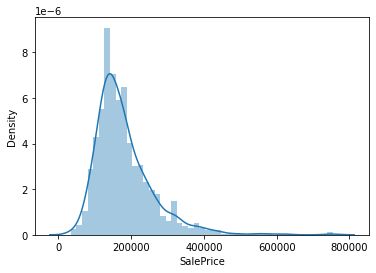

In [31]:
sns.distplot(train_data['SalePrice'])

Min sale price is greater than 0, which is a good thing. Looking at the plot, we can consider 'SalePrice' > 500000 outliners.

@todo: The data is slightly skewed. You should try to deal with it later.

# **2. Preprocessing data**

## 2.1. Identifying important features

To identify which features are important, we can look at the relationship between each feature and the target variables.

@todo: Here we have 80 features. It will take a while to examine them one-by-one. For the purpose of this notebook, I only plot some relationships I think are important. You should take your time with as many as you can.

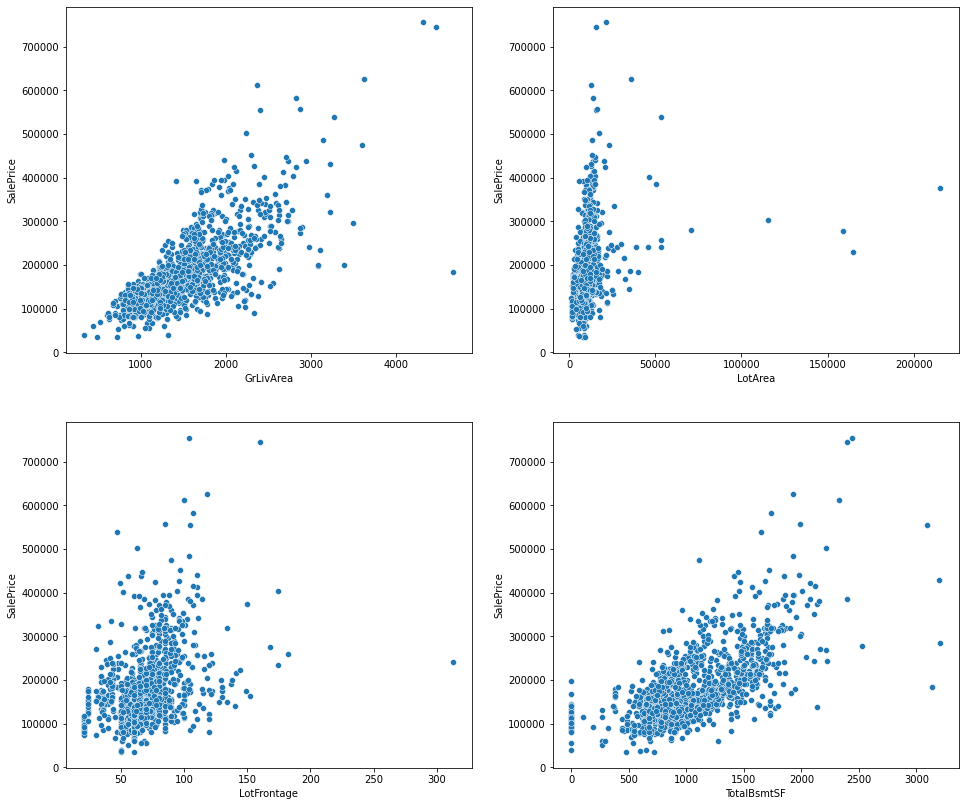

In [32]:
# Important numerical features
numerical_features = [
    'GrLivArea',
    'LotArea',
    'LotFrontage',
    'TotalBsmtSF',
]
plot_relationships_numerical(train_data, 'SalePrice', numerical_features)

The plot of LotArea/SalePrice is a bit hard to see because of the outliers. We can exclude them to see clearer. 

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

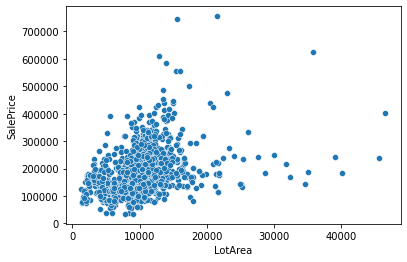

In [33]:
sns.scatterplot(x=train_data[train_data['LotArea'] < 50000]['LotArea'],
                y=train_data[train_data['LotArea'] < 50000]['SalePrice'])

We can see that 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF' all have positive linear correlation with SalePrice. Which make sense: the bigger the house/frontage, the higher the price.

Now for the categorical features

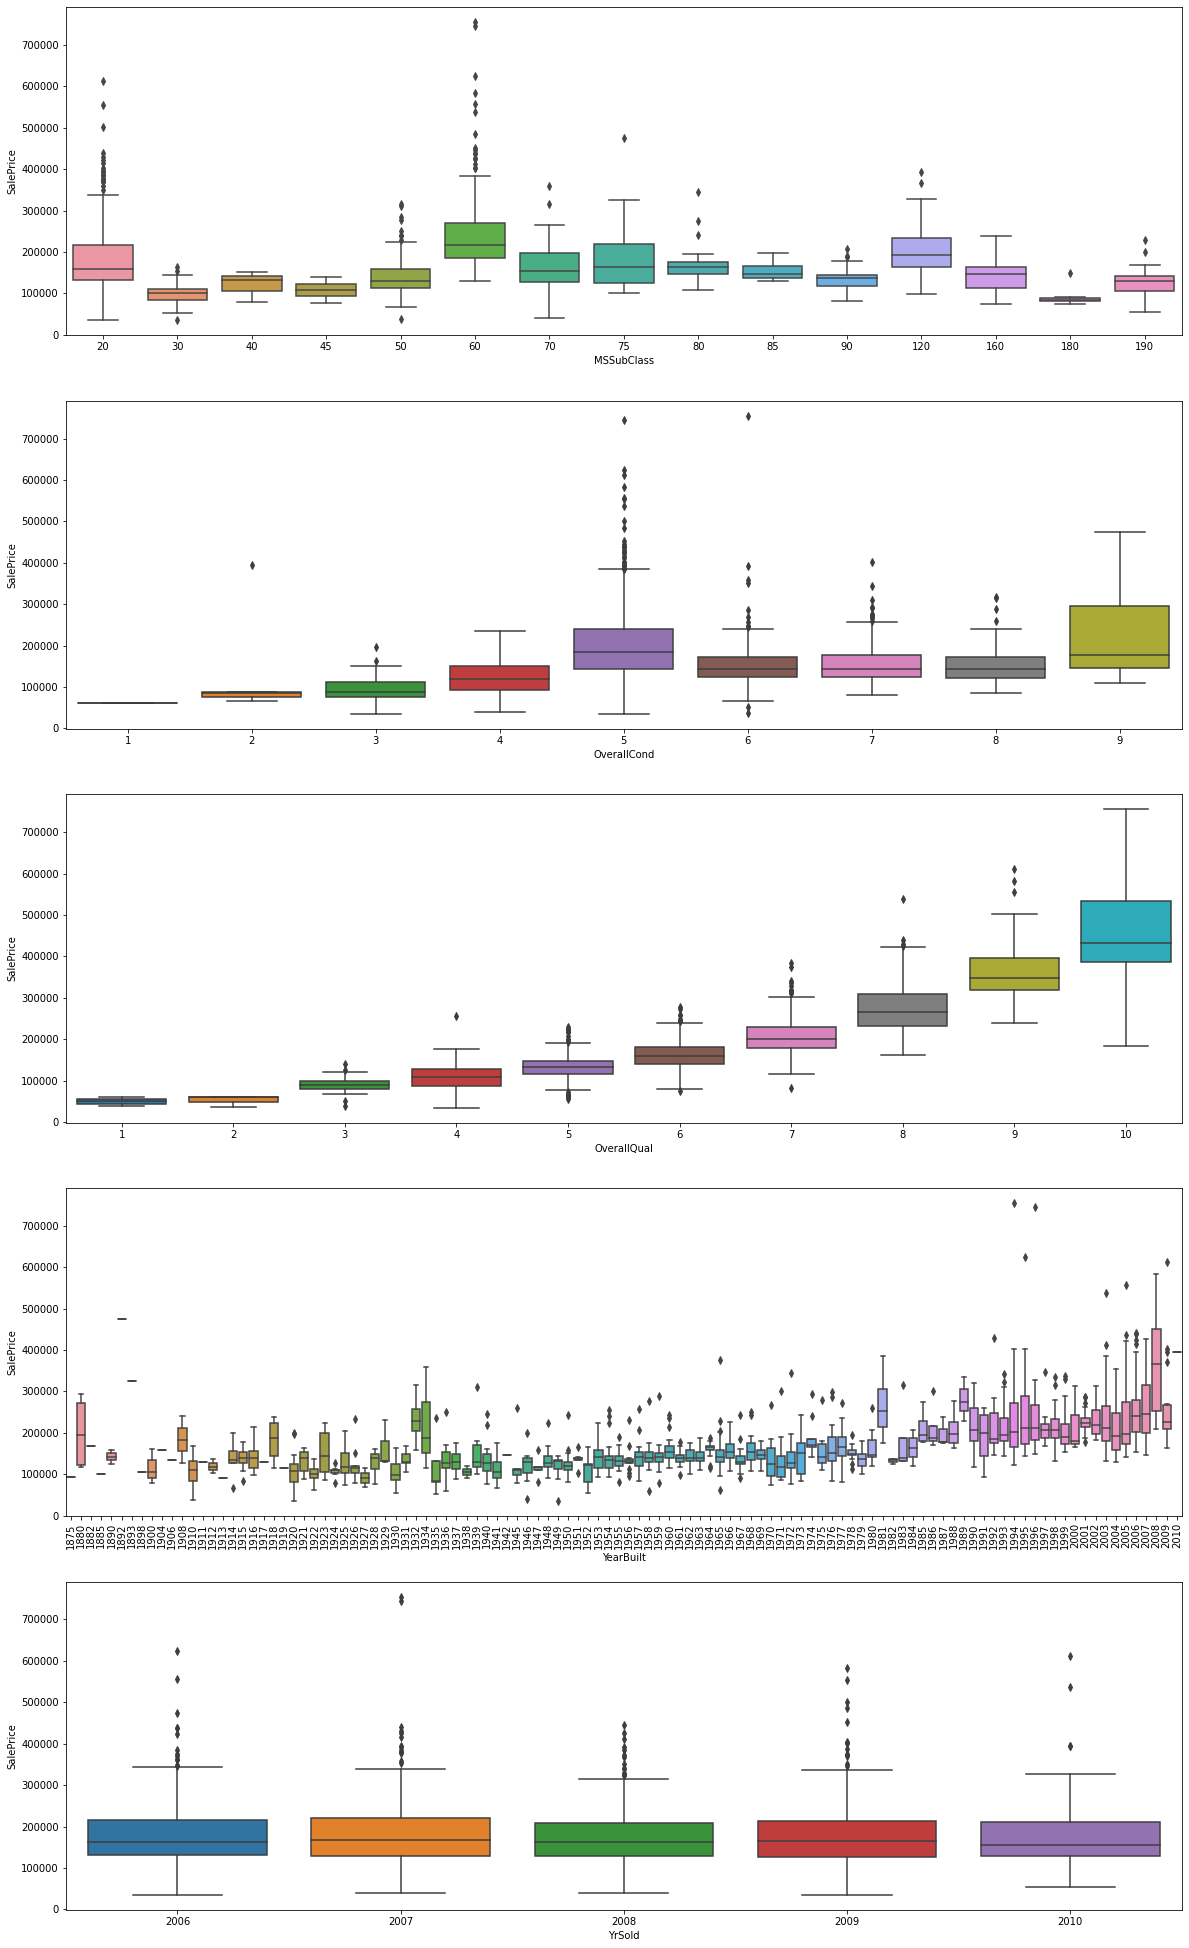

In [34]:
# Important categorical features
categorical_features = [
    'MSSubClass',
    'OverallCond',
    'OverallQual',
    'YearBuilt',
    'YrSold',
]

plot_relationships_categorical(
    train_data, 'SalePrice', categorical_features)

'OverallCond', 'OverallQual' and 'YearBuilt' seem to share some connections with 'SalePrice', particularly in the case of 'OverallQual'.

'MSSubClass' and 'YrSold' don't seem to affect 'SalePrice', which is interesting because 2006-2010 was the time of [the Great Recession in the U.S](https://en.wikipedia.org/wiki/Great_Recession_in_the_United_States). It seems either Iowa (where this data is taken from) wasn't affected, or the prices were inflation-adjusted.

- More insight: https://en.wikipedia.org/wiki/United_States_housing_bubble

Our intuitions can only get us this far. To systematically see the relations between our features, there is a better way: correlation matrix.

<AxesSubplot:>

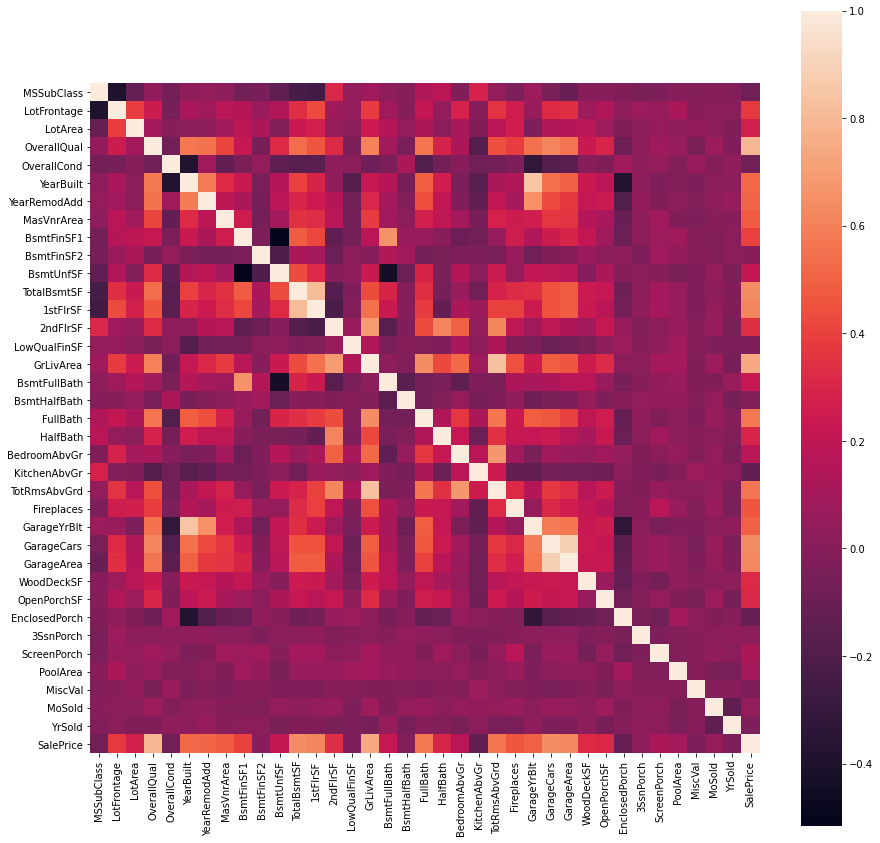

In [36]:
corrmat = train_data.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, square=True)

Here we can spot some strongly-correlated pair of features by looking for the bright-color cells. Note that we don't have any very strong negative correlation here.

- 'GarageArea' and 'GarageCars': Well of course, bigger garages can hold more cars. We probably only need one of them.
- 'TotalBsmtSF' and '1stFlrSF': This is obvious too. Basement area and 1st floor area should be about the same, unless it's a CIA's property!

Other than that, we should note the variables correlated strongly with 'SalePrice'. They are 'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars' and 'GarageArea'.

@todo: Try to sort the features by their correlations with 'SalePrice' and plot the relationships between those at the top.

## 2.2. Clean the data 

### 2.2.1 Drop outliers and combine train-test data

In [37]:
# Drop outliers
train_data = drop_outliers(train_data, 'SalePrice', 500000)

# Concat train and test set to get a complete view of our data.
all_data = (
    train_data
        .append(test_data, sort=False, ignore_index=True)
        .drop(['SalePrice'], axis=1)
)

### 2.2.2. Deal with missing data

Let's see which columns have the most missing data.

In [38]:
print('Missing values in training data')
print(show_missing(train_data))

Missing values in training data
              Total   Percent
PoolQC         1239  0.997585
MiscFeature    1191  0.958937
Alley          1167  0.939614
Fence          1003  0.807568
FireplaceQu     594  0.478261
LotFrontage     216  0.173913
GarageType       71  0.057166
GarageYrBlt      71  0.057166
GarageFinish     71  0.057166
GarageQual       71  0.057166
GarageCond       71  0.057166
BsmtFinType2     36  0.028986
BsmtExposure     36  0.028986
BsmtCond         35  0.028180
BsmtQual         35  0.028180
BsmtFinType1     35  0.028180


In [39]:
print('Missing values in test data')
print(show_missing(test_data))

Missing values in test data
              Total  Percent
MiscFeature     197    0.985
PoolQC          197    0.985
Alley           185    0.925
Fence           159    0.795
FireplaceQu      91    0.455
LotFrontage      41    0.205
GarageQual       10    0.050
GarageType       10    0.050
GarageYrBlt      10    0.050
GarageFinish     10    0.050
GarageCond       10    0.050
BsmtFinType2      2    0.010
BsmtFinType1      2    0.010
BsmtCond          2    0.010
BsmtQual          2    0.010
BsmtExposure      2    0.010


In [40]:
print('Missing values in both training and test data')
print(show_missing(all_data))

Missing values in both training and test data
              Total   Percent
PoolQC         1436  0.995839
MiscFeature    1388  0.962552
Alley          1352  0.937587
Fence          1162  0.805825
FireplaceQu     685  0.475035
LotFrontage     257  0.178225
GarageQual       81  0.056172
GarageType       81  0.056172
GarageYrBlt      81  0.056172
GarageFinish     81  0.056172
GarageCond       81  0.056172
BsmtExposure     38  0.026352
BsmtFinType2     38  0.026352
BsmtFinType1     37  0.025659
BsmtCond         37  0.025659
BsmtQual         37  0.025659


#### 2.2.2.1. PoolQC, MiscFeature, Alley, Fence and FireplaceQu

In [41]:
# According to the document, a N/A in these columns indicates
# the lack of that particular feature. With more than 90% missing
# in the former 3, I don't think they will contribute much for our model,
# so I'll delete them.

# For 'Fence' and 'FireplaceQu', I don't think fence and fireplace are
# things we put much thought on when we choose a house. Removing them
# shouldn't pose any big problem.
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'],
              axis=1, inplace=True)

# @todo: These are only my own speculations.
# You are free to make your owns and act accordingly.

#### 2.2.2.2. LotFrontage

In [42]:
# The frontage of a house is most likely similar to other houses'
# in the neighborhood, so we can try using the median
# of the neighborhood's frontage values.

# @todo: You can try more complicated strategies, for example build a model
# to predict the missing values bases on 'Neighborhood'
# and some area-related variables.
all_data['LotFrontage'] = (all_data.groupby('Neighborhood')['LotFrontage']
                           .transform(lambda x: x.fillna(x.median())))

#### 2.2.2.3. Garage-related features

In [43]:
# A N/A in 'GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish' and
# 'GarageType' means "no garage".
fill_dict = {
    'GarageCond': 'N/A',
    'GarageFinish': 'N/A',
    'GarageQual': 'N/A',
    'GarageType': 'N/A',
    'GarageYrBlt': 0,  # GarageYrBlt is of numerical type
}
columns_to_fill = list(fill_dict.keys())
all_data[columns_to_fill] = all_data[columns_to_fill].fillna(fill_dict)

#### 2.2.2.4. Basement-related features

<AxesSubplot:>

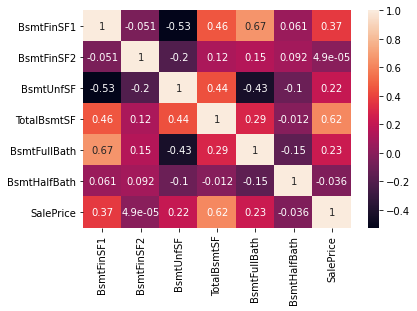

In [44]:
# There are too many basement-related features here.
# Some of them might not be important.

# Here we use train_data because we need SalePrice
basement_data = train_data.filter(regex='(.*Bsmt.*|SalePrice)')
basement_correlation = basement_data.corr()
sns.heatmap(basement_correlation, cbar=True, annot=True)

In [45]:
# 'BsmtFinSF2' and 'BsmtHalfBath' have almost zero correlation
# with 'SalePrice'. We can safely throw them out.
# And 'BsmtFinType2' goes out together with 'BsmtFinSF2'.
all_data.drop(['BsmtFinSF2', 'BsmtFinType2', 'BsmtHalfBath'],
              axis=1, inplace=True)

# Let's look again at the missing data in the remaining columns.
basement_data = all_data.filter(regex='.*Bsmt.*')
show_missing(basement_data)

,Total,Percent
BsmtExposure,38,0.026352
BsmtQual,37,0.025659
BsmtCond,37,0.025659
BsmtFinType1,37,0.025659


In [46]:
# A N/A in the above columns indicates "No basement".

columns_to_fill = [
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtQual',
]
all_data[columns_to_fill] = all_data[columns_to_fill].fillna('N/A')

# @todo We have an inconsistency here. There are 38 missing 'BsmtExposure'
# but only 37 in the other basement-related columns.
# You can try investigating and deal with it.

In [47]:
# There should be no more missing data.
show_missing(all_data)

,Total,Percent


# **3. Feature engineering**

In [48]:
# Let's look at the data again.
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1442 non-null   int64  
 1   MSZoning       1442 non-null   object 
 2   LotFrontage    1442 non-null   float64
 3   LotArea        1442 non-null   int64  
 4   Street         1442 non-null   object 
 5   LotShape       1442 non-null   object 
 6   LandContour    1442 non-null   object 
 7   Utilities      1442 non-null   object 
 8   LotConfig      1442 non-null   object 
 9   LandSlope      1442 non-null   object 
 10  Neighborhood   1442 non-null   object 
 11  Condition1     1442 non-null   object 
 12  Condition2     1442 non-null   object 
 13  BldgType       1442 non-null   object 
 14  HouseStyle     1442 non-null   object 
 15  OverallQual    1442 non-null   int64  
 16  OverallCond    1442 non-null   int64  
 17  YearBuilt      1442 non-null   int64  
 18  YearRemo

In [49]:
# Here I choose to learn only from a few features with high correlation
# with SalePrice.
columns_to_take = [
    '1stFlrSF',
    'FullBath',
    'GarageCars',
    'GrLivArea',
    'OverallQual',
    'TotalBsmtSF',
    'TotRmsAbvGrd',
    'YearBuilt',
]
all_data = all_data[columns_to_take]


# A lot of numerical variables are actually categorical:
# 'MSSubClass', 'OverallQual', 'OverallCond', etc.
# We should change them appropriately.
# to_categorical = [
#     'OverallQual',
#     'YearBuilt',
# ]
# all_data[to_categorical] = all_data[to_categorical].astype(str)


# Transform categorical variables into numerical values
# might increase model's accuracy
# all_data = pd.get_dummies(all_data)



# @todo: Lots of things to do here. For example:
# - Remove some columns that you think don't contribute much to the price.
# - Add some features that might be important.
# - Deal with categorical variables differently.
# - Correct the skewness of some variables.

In [50]:
all_data.head()

,1stFlrSF,FullBath,GarageCars,GrLivArea,OverallQual,TotalBsmtSF,TotRmsAbvGrd,YearBuilt
0,856,2,2,1710,7,856,8,2003
1,1262,2,2,1262,6,1262,6,1976
2,920,2,2,1786,7,920,6,2001
3,961,1,3,1717,7,756,7,1915
4,1145,2,3,2198,8,1145,9,2000


# **4. Modeling**

In [51]:
from sklearn import linear_model, model_selection, metrics

# Some more helper functions.
# You don't have to care about them if you don't understand.

def cross_validation(model, x_train, y_train, n_folds=5):
    """Cross validation with shuffle."""
    kfold = (
        model_selection.KFold(n_folds, shuffle=True, random_state=20190216)
            .get_n_splits(x_train)
    )
    rmse = np.sqrt(-model_selection.cross_val_score(
        model,
        x_train,
        y_train,
        scoring="neg_mean_squared_error",
        cv=kfold
    ))
    return rmse


def rmse(y_test, y_pred):
    """Root mean square error."""
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))


def test(model, x_test, y_test):
    """Make predictions and compare with test data."""
    y_pred = model.predict(x_test)
    return rmse(y_test, y_pred), metrics.r2_score(y_test, y_pred)

In [52]:
# Split data back into train set and test set
y_train = train_data['SalePrice']
train_data = all_data[:len(train_data)]
test_data = all_data[len(train_data):]

In [53]:
train_data.head()

,1stFlrSF,FullBath,GarageCars,GrLivArea,OverallQual,TotalBsmtSF,TotRmsAbvGrd,YearBuilt
0,856,2,2,1710,7,856,8,2003
1,1262,2,2,1262,6,1262,6,1976
2,920,2,2,1786,7,920,6,2001
3,961,1,3,1717,7,756,7,1915
4,1145,2,3,2198,8,1145,9,2000


In [54]:
# A simple baseline model.

linear_regression = linear_model.LinearRegression()
linear_regression.fit(train_data, y_train)
rmse_score, r2_score = test(linear_regression, test_data, test_ans)
print(f'Linear Regression score: RMSE={rmse_score:.4f}, R2={r2_score:.4f}')

Linear Regression score: RMSE=45963.1871, R2=0.5914
